# WINE CROSS-VALIDATION EXERCISE - SOLUTION

In [1]:
# Activate inline plots.
%matplotlib inline

# Useful imports for the exercises.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('notebook')

## EXERCISE 1

Revise the results of the "wine regression" exercise using cross-validation to set the hyper-parameters.

Use your favorite method, or if you don't have one, try setting the "alpha" parameter 
for a Ridge regressor.

In [2]:
# Read the data and print some summary information.
df = pd.read_table('data/wine_quality-red.csv', sep=';')

In [3]:
# List of column names containing all the features for regression.
features = df.columns.difference(['quality'])
# The name of the column for the output varaible.
target = 'quality'

We start with some pre-processing:

1. Divide the data in a training and a test set (to evaluate the algorith *after* cross-validation)
2. Transform non-gaussian variables through a non-linearity

In [4]:
from sklearn.cross_validation import train_test_split

x = df[features]
t = np.squeeze(df[target])

# Divide the data into a training and a test set.
random_state = 0  # Fixed so that everybody has got the same split
test_set_fraction = 0.2
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=test_set_fraction, 
                                                    random_state=random_state)

print 'Size of training set:', len(x_train)
print 'Size of test set:', len(x_test)

Size of training set: 1279
Size of test set: 320


In [5]:
# Transform non-gaussian variables using a log transform.
cols = ['alcohol', 'chlorides', 'citric acid', 'free sulfur dioxide', 'residual sugar', 'total sulfur dioxide']
df[cols] = df[cols].apply(lambda x: np.log(x + 0.1))

## Cross-validation

In this section we will search for the optimal parameters for a Support Vector Regressor.

First, we need to define the method with which we are going to generate the cross-validation sets.

In [6]:
from sklearn import cross_validation
cv = cross_validation.ShuffleSplit(len(t_train), n_iter=4, test_size=0.3)

Second, we consider a grid of parameters for `gamma` (the width of the radial basis functions) and `C` (a regularization term, smaller means larger margin).

In [7]:
# These are the parameters that we're going to consider.
gammas = np.logspace(-4, 0., 6) * 0.5
Cs = [0.1, 1., 10., 100., 1000.]

Third, we create the pipeline that we want to train.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

workflow = Pipeline([('scaler', StandardScaler()), ('regressor', SVR())])

In [9]:
from sklearn.grid_search import GridSearchCV

param_grid = [{'regressor__kernel': ['rbf'], 'regressor__gamma': gammas, 'regressor__C': Cs}]

grid_search = GridSearchCV(workflow, param_grid, cv=cv, n_jobs=8)
grid_search.fit(x_train, t_train);

<matplotlib.colorbar.Colorbar instance at 0x114a1c950>

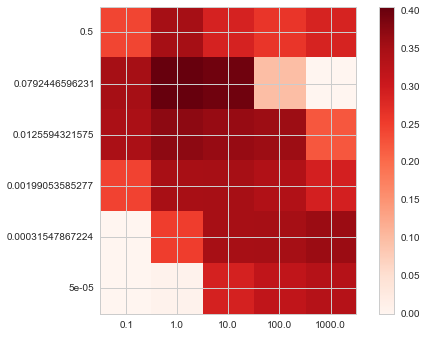

In [10]:
scores = [score.mean_validation_score for score in grid_search.grid_scores_]
scores = np.array(scores).reshape(len(Cs), len(gammas)).T

# Visualize the results as an image.
plt.imshow(scores.clip(0), interpolation='nearest', cmap='Reds', origin='lower')
plt.xticks(range(len(Cs)), Cs)
plt.yticks(range(len(gammas)), gammas)
plt.colorbar()

In [11]:
grid_search.best_params_

{'regressor__C': 1.0,
 'regressor__gamma': 0.079244659623055713,
 'regressor__kernel': 'rbf'}

## Compute prediction performance

Finally, we use the `grid_search` object as an estimator, to compute the final score using the test data set.

In [12]:
# Compute the final score.
print 'Training R^2 = {:.4f}'.format(grid_search.score(x_train, t_train))
print '    Test R^2 = {:.4f}'.format(grid_search.score(x_test, t_test))

Training R^2 = 0.5403
    Test R^2 = 0.3460
